In [28]:
from os import listdir
from os.path import isfile, join
import pathlib
import xml.etree.ElementTree as ET
import glob
import os
import xmltodict
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import numpy as np
from pandas import DataFrame
from matplotlib.collections import QuadMesh
import seaborn as sn
import matplotlib.font_manager as fm

In [29]:
class_map = {
    "Composite Restoration":0,
    "restoration":1,
    "periapical lesion":2,
    "Caries Into Dentin":3,
    "endodontic treatment":4,
    "dental implant":5,
}

In [30]:
def parse_xml_file(xml_file_path:str)->dict:
    """Parses an xml file and returns all objects, and the filename
    Args:
        xml_file_path: Path to the xml file
    Returns:
        A dictionary with keys: 
            * file_name - the name of the image file
            * objects - a list of dictionary objects where each object 
    """
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    res = {
        "file_name":root.find("filename").text,
        "width":root.find("size").find("width").text,
        "height":root.find("size").find("height").text,
    }

    objs = []
    for box_idx, member in enumerate(root.findall("object")):
        obj = {}
        bbox = member.find("bndbox")
        obj["x1"] = int(float(bbox.find("xmin").text))
        obj["y1"] = int(float(bbox.find("ymin").text))
        obj["x2"] = int(float(bbox.find("xmax").text))
        obj["y2"] = int(float(bbox.find("ymax").text))
        obj["class"] = member[0].text
        objs.append(obj)
    
    res["objects"] = objs

    return res

In [31]:
print("Found {} files in data directory!".format(str(len(glob.glob("output/annotations/train/*.xml")))))
for file in glob.glob("output/annotations/train/*.xml"):
    f_handle = open(file, 'r')
pascal_voc_contents = xmltodict.parse(f_handle.read())


Found 1 files in data directory!


In [32]:
images = []
for i in range(len(pascal_voc_contents['annotations']['image'])):
    imgfile = pascal_voc_contents['annotations']['image'][i]['@name']    
    images.append(imgfile)

In [33]:
len(images)

17357

In [34]:
img

'OEE_9_11.jpg'

In [35]:
i

17356

In [17]:
xml_file = 'input\\'+pascal_voc_contents['annotations']['image'][i]['@id']+".xml"
file_data = parse_xml_file(xml_file)    
file_data

{'file_name': '5c2a4368556547acace7174b3fce4c19_5.jpg',
 'width': '43',
 'height': '63',
 'objects': [{'x1': 22,
   'y1': 42,
   'x2': 36,
   'y2': 57,
   'class': 'Composite Restoration'}]}

In [36]:
i=0
ground = []
pred = []
for img in images:            
    #screen = cv2.imread('input/'+img)
    
    xml_file = 'input\\'+pascal_voc_contents['annotations']['image'][i]['@id']+".xml"
    if 'box' in pascal_voc_contents['annotations']['image'][i]:
        boxes = pascal_voc_contents['annotations']['image'][i]['box']
    else:
        boxes = None
        
    file_data = parse_xml_file(xml_file)    
    temp_pred = []
    if isinstance(boxes,list):        
        for box in boxes:
            conf = box['@confidence']
            if float(conf)<0.2:
                continue
            label_ = box['@label']            
            check = False
            if label_ =='Composite Restoration':
                if float(conf)>0.25:
                    check=True
            elif label_ =='restoration':
                if float(conf)>0.25:
                    check=True
            elif label_ =='Caries Into Dentin':
                if float(conf)>0.25:
                    check=True
            else:
                check=True
            if check:
                label_ = box['@label']
                
                xmin,ymin,xmax,ymax = int(float(box['@xtl'])),int(float(box['@ytl'])),int(float(box['@xbr'])),int(float(box['@ybr']))        
                label_ = box['@label']
                width = xmax - xmin
                height = ymax - ymin                
                #temp_pred.append(box)
                temp_pred.append([float(box['@xtl']),float(box['@ytl']),float(box['@xbr']),float(box['@ybr']),float(conf),class_map[box['@label']]])
    elif isinstance(boxes,dict):   
        temp_pred.append([float(boxes['@xtl']),float(boxes['@ytl']),float(boxes['@xbr']),float(boxes['@ybr']),float(box['@confidence']), class_map[box['@label']]])
    pred.append(temp_pred)
    temp_pred = []
    for row in file_data['objects']:        
        temp_pred.append([class_map[row['class']],row['x1'],row['y1'],row['x2'],row['y2'],])
    ground.append(temp_pred)
    
    i+=1

In [37]:
len(ground)

17357

In [38]:
len(pred)

17357

In [39]:
def box_iou_calc(boxes1, boxes2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Array[N, 4])
        boxes2 (Array[M, 4])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    This implementation is taken from the above link and changed so that it only uses numpy..
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])
    

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min = 0, a_max = None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)


class ConfusionMatrix:
    def __init__(self, num_classes, CONF_THRESHOLD = 0.3, IOU_THRESHOLD = 0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD
    
    def process_batch(self, detections, labels):
        '''
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        '''
        detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        gt_classes = labels[:, 0].astype(np.int16)
        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = []
        for i in range(want_idx[0].shape[0]):
            all_matches.append([want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]])
        
        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0: # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index = True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index = True)[1]]


        for i, label in enumerate(labels):
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                gt_class = gt_classes[i]
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[(gt_class), detection_class] += 1
            else:
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, (gt_class)] += 1
        
        for i, detection in enumerate(detections):
            if all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0:
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))

In [40]:
conf_mat = ConfusionMatrix(num_classes = 6, CONF_THRESHOLD = 0.3, IOU_THRESHOLD = 0.5)
for i in range(len(pred)):    
    pred1=np.array([xi for xi in pred[i]])
    ground1=np.array([xi for xi in ground[i]])
    if pred1.size == 0: # FN across the board!
        for truth in ground1: # update corresponding final row  
            conf_mat.matrix[truth[0], -1] += 1            
    else:
        conf_mat.process_batch(pred1, ground1)

In [23]:
pred

[[[1.9096626, 64.09808, 28.790747, 87.10034, 0.617798, 1],
  [28.345592, 63.380264, 37.39124, 87.98084, 0.4130859, 1]],
 [[6.407335, 72.39687, 41.096214, 91.98937, 0.59679765, 1]],
 [[0.16603772, 0.0, 14.097581, 13.863524, 0.11424106, 0]],
 [[8.223066, 8.558014, 50.95105, 46.383205, 0.7321848, 1]],
 [[26.876953, 101.68073, 57.23267, 118.296616, 0.30483714, 0]],
 [[16.221426, 53.763866, 78.154625, 150.1473, 0.8863338, 4]],
 [[0.0, 105.498184, 12.850616, 127.92803, 0.48130468, 0]],
 [],
 [[11.2605915, 12.114258, 38.362553, 36.633762, 0.40743265, 1],
  [0.15854773, 14.017376, 8.00028, 43.302124, 0.34805897, 1]],
 [[2.9218462, 58.415913, 35.609783, 78.74132, 0.59415567, 0],
  [1.031594, 61.59413, 3.9501836, 80.34987, 0.26611108, 0]],
 [[0.0027732179, 62.722202, 13.942957, 83.1766, 0.30147362, 0]],
 [[4.1332016, 24.205957, 43.637016, 76.244774, 0.77702737, 4],
  [0.0, 1.770382, 14.858546, 18.393747, 0.27950662, 0]],
 [[10.971238, 6.9986, 36.936115, 60.38506, 0.852388, 4]],
 [[1.5326653, 14.

In [41]:
def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'    
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    yticklabels = list(class_map.keys())+['sum_lin']
    xticklabels = list(class_map.keys())+['sum_col']
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt,yticklabels=yticklabels,xticklabels=xticklabels)
    
    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()

<ipython-input-41-4b8cacf88c68>:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]


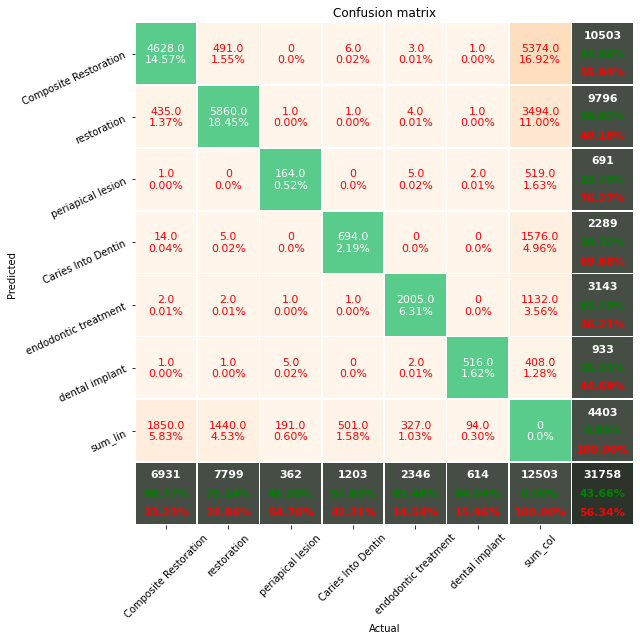

In [42]:
fz = 11;
figsize=[9,9];
show_null_values = 2
cmap = 'Oranges';
pred_val_axis = 'y'
df_cm = DataFrame(conf_mat.matrix, index=range(1,8), columns=range(1,8))
pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

In [26]:
conf_mat.matrix

array([[4.628e+03, 4.350e+02, 1.000e+00, 1.400e+01, 2.000e+00, 1.000e+00,
        1.850e+03],
       [4.910e+02, 5.860e+03, 0.000e+00, 5.000e+00, 2.000e+00, 1.000e+00,
        1.440e+03],
       [0.000e+00, 1.000e+00, 1.640e+02, 0.000e+00, 1.000e+00, 5.000e+00,
        1.910e+02],
       [6.000e+00, 1.000e+00, 0.000e+00, 6.940e+02, 1.000e+00, 0.000e+00,
        5.010e+02],
       [3.000e+00, 4.000e+00, 5.000e+00, 0.000e+00, 2.005e+03, 2.000e+00,
        3.270e+02],
       [1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 5.160e+02,
        9.400e+01],
       [5.374e+03, 3.494e+03, 5.190e+02, 1.576e+03, 1.132e+03, 4.080e+02,
        0.000e+00]])

In [27]:
IOU_THRESHOLD = 0.5
results = []
for class_name, class_id in class_map.items():
    total_target = np.sum(conf_mat.matrix[class_id,:])
    total_predicted = np.sum(conf_mat.matrix[:,class_id])
    precision = float(conf_mat.matrix[class_id, class_id] / total_predicted)
    recall = float(conf_mat.matrix[class_id, class_id] / total_target)
    print('precision_{}@{}IOU: {:.2f}'.format(class_name, IOU_THRESHOLD, precision))
    print('recall_{}@{}IOU: {:.2f}'.format(class_name, IOU_THRESHOLD, recall))
    results.append({'category' : class_name, 'precision_@{}IOU'.format(IOU_THRESHOLD) : precision, 'recall_@{}IOU'.format(IOU_THRESHOLD) : recall})
    df = DataFrame(results)
df

precision_Composite Restoration@0.5IOU: 0.44
recall_Composite Restoration@0.5IOU: 0.67
precision_restoration@0.5IOU: 0.60
recall_restoration@0.5IOU: 0.75
precision_periapical lesion@0.5IOU: 0.24
recall_periapical lesion@0.5IOU: 0.45
precision_Caries Into Dentin@0.5IOU: 0.30
recall_Caries Into Dentin@0.5IOU: 0.58
precision_endodontic treatment@0.5IOU: 0.64
recall_endodontic treatment@0.5IOU: 0.85
precision_dental implant@0.5IOU: 0.55
recall_dental implant@0.5IOU: 0.84


,category,precision_@0.5IOU,recall_@0.5IOU
0,Composite Restoration,0.440636,0.667725
1,restoration,0.598203,0.751378
2,periapical lesion,0.237337,0.453039
3,Caries Into Dentin,0.303189,0.576891
4,endodontic treatment,0.637926,0.854646
5,dental implant,0.553055,0.840391
